In [18]:
# imports
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import networkx as nx

Problem 1.

\begin{aligned}
\max_{x, z} \quad & z \\[6pt]
\text{s.t.} \quad & z \leq \langle r_k, x \rangle, \quad k = 1, 2, \ldots, K \\
& \sum_{i=1}^{n} x_i = 1 \\
& x_i \geq 0, \quad i = 1, 2, \ldots, n
\end{aligned}

In [19]:
import numpy as np
from scipy.optimize import linprog

R = np.array([
    [1.40, 0.60, 0.76, 0.65, 1.45, 1.05, 0.84, 1.04],
    [0.63, 1.28, 1.22, 1.25, 0.83, 1.44, 1.10, 1.51],
    [1.28, 0.79, 0.65, 1.25, 0.77, 0.87, 0.98, 1.20],
    [1.54, 1.42, 1.47, 1.15, 1.16, 0.75, 0.71, 1.23],
    [0.71, 0.96, 0.91, 1.50, 0.98, 0.79, 1.51, 1.25],
    [1.23, 0.89, 0.84, 1.51, 0.80, 1.29, 0.72, 0.92],
    [1.25, 0.81, 0.91, 1.12, 0.90, 1.00, 0.84, 0.96],
    [1.45, 0.92, 0.79, 1.07, 0.75, 1.39, 0.82, 1.06],
    [1.12, 1.07, 0.94, 0.95, 0.72, 1.36, 0.95, 0.69],
    [1.17, 1.38, 1.25, 1.09, 1.03, 1.32, 1.24, 1.24],
    [1.00, 0.97, 0.62, 1.14, 0.79, 1.29, 0.93, 0.94],
    [0.88, 1.14, 1.45, 0.61, 1.26, 1.53, 0.56, 0.57]
])

K, n = R.shape

c = np.zeros(n + 1)
c[-1] = -1

A_ub = []
b_ub = []

for k in range(K):
    row = np.zeros(n + 1)
    row[:n] = -R[k]
    row[-1] = 1
    A_ub.append(row)
    b_ub.append(0)

A_ub = np.array(A_ub)
b_ub = np.array(b_ub)

A_eq = np.zeros((1, n + 1))
A_eq[0, :n] = 1
b_eq = np.array([1])

bounds = [(0, None)] * n + [(None, None)]

result = linprog(c, A_ub=A_ub, b_ub=b_ub,
                 A_eq=A_eq, b_eq=b_eq,
                 bounds=bounds)

x_opt = result.x[:n]
t_opt = result.x[-1]

print(x_opt)
print(t_opt)


#This is a convex problem since you're trying to minimize. A convex diagram is looking upward.


[0.17694623 0.         0.         0.33863231 0.18949996 0.2949215
 0.         0.        ]
1.0522782362638208


Problem 2.

$$\min_{a_1, a_2, a_3, b} \quad \sum_{i=1}^{20} \left| a_1 \cdot \text{Man}_i + a_2 \cdot \text{Ene}_i + a_3 \cdot \text{Mat}_i + b - y_i \right|^{\alpha}$$

$$\text{where the underlying linear regression model is:}$$

$$\text{Output} = a_1 \times \text{Manpower} + a_2 \times \text{Energy} + a_3 \times \text{Materials} + b$$

$$\text{for } \alpha > 0 \text{ and } i = 1, 2, \ldots, 20$$

In [20]:
np.random.seed(0)

n = 20

Manpower = np.random.uniform(10, 50, n)
Energy = np.random.uniform(5, 30, n)
Materials = np.random.uniform(20, 60, n)

true_a1 = 2.0
true_a2 = -1.5
true_a3 = 0.8
true_b = 5.0

noise = np.random.normal(0, 5, n)

y = (true_a1 * Manpower +
     true_a2 * Energy +
     true_a3 * Materials +
     true_b +
     noise)

alpha = 1.5

def objective(params):
    a1, a2, a3, b = params
    residuals = a1 * Manpower + a2 * Energy + a3 * Materials + b - y
    return np.sum(np.abs(residuals) ** alpha)

initial_guess = np.zeros(4)

result = minimize(objective, initial_guess)

a1_opt, a2_opt, a3_opt, b_opt = result.x

print(a1_opt, a2_opt, a3_opt, b_opt)

2.0467294405310326 -1.6592604226541345 0.7171162623205636 7.530444619446582


Problem 3.

\begin{aligned}
\max_{x} \quad & \sum_{t=1}^{T} \beta^t u(x_t) + \beta^T U(w_T) \\[6pt]
\text{s.t.} \quad & w_{t+1} = (1 + r)(w_t - x_t), \quad t = 1, 2, \ldots, T-1 \\
& w_0 = 100 \\
& x, w \geq 0
\end{aligned}

In [21]:
# Define all parameters
gamma = 2  # Risk aversion parameter
beta = 0.95  # Discount factor
r = 0.05  # Interest rate
W0 = 100  # Initial wealth
T = 10  # Time periods
bequest_weight = 0.5  # Weight on bequest utility
income = np.array([50, 50, 50, 50, 50, 40, 40, 30, 20, 10])  # Income each period

# Step 1: Define utility function (CRRA - Constant Relative Risk Aversion)
def u(c):
    """Consumption utility"""
    if gamma == 1:
        return np.log(c)
    else:
        return (c**(1 - gamma)) / (1 - gamma)

# Step 2: Define bequest function
def U(w):
    """Utility from leaving a bequest"""
    return bequest_weight * u(w)

# Step 3: Define objective function to minimize (negative of total utility)
def objective(c):
    """Calculate negative total utility (we minimize to maximize)"""
    total_utility = 0
    wealth = W0
    
    # Sum utility from consumption over all periods
    for t in range(T):
        total_utility += (beta**(t+1)) * u(c[t])
        wealth = (1 + r) * (wealth - c[t])
    
    # Add bequest utility at the end
    total_utility += (beta**T) * U(wealth)
    
    return -total_utility

# Step 4: Define budget constraint (final wealth must be non-negative)
def budget_constraint(c):
    """Track wealth and ensure it doesn't go negative"""
    wealth = W0
    for t in range(T):
        wealth = (1 + r) * (wealth - c[t])
    return wealth

# Step 5: Set up optimization problem
constraints = {'type': 'ineq', 'fun': budget_constraint}
bounds = [(0.1, None) for _ in range(T)]  # Each period's consumption ≥ 0.1
c_init = np.ones(T) * 30  # Initial guess: consume 30 each period

# Step 6: Solve the optimization
result = minimize(objective, c_init, method='SLSQP', bounds=bounds, constraints=constraints)

# Step 7: Extract and display results
optimal_consumption = result.x
print("Optimization successful:", result.success)
print("\nOptimal consumption path:")
for t in range(T):
    print(f"Period {t+1}: {optimal_consumption[t]:.2f}")

# Step 8: Calculate wealth path and bequest
wealth_path = [W0]
for t in range(T):
    new_wealth = (1 + r) * (wealth_path[-1] - optimal_consumption[t])
    wealth_path.append(new_wealth)

bequest = wealth_path[-1]
savings = income - optimal_consumption

print(f"\nFinal wealth (bequest): {bequest:.2f}")
print(f"Total utility: {-result.fun:.6f}")

Optimization successful: False

Optimal consumption path:
Period 1: 10.26
Period 2: 11.33
Period 3: 17.64
Period 4: 9.74
Period 5: 5.70
Period 6: 20.03
Period 7: 11.01
Period 8: 19.16
Period 9: 7.87
Period 10: 9.17

Final wealth (bequest): 1.78
Total utility: -0.888979


Problem 4.

\begin{aligned}
\min_{x} \quad & \sum_{(i,j) \in \mathcal{A}} c_{ij} \cdot x_{ij}^{\alpha} \\[6pt]
\text{s.t.} \quad & \sum_{j:(i,j) \in \mathcal{A}} x_{ij} - \sum_{j:(j,i) \in \mathcal{A}} x_{ji} = b_i, \quad \forall \, i \in \mathcal{N} \\
& 0 \leq x_{ij} \leq u_{ij}, \quad \forall \, (i,j) \in \mathcal{A}
\end{aligned}

  NONLINEAR TRANSSHIPMENT PROBLEM SOLUTION
  Cost function: c_ij * x_ij^1.5

Arc                Flow   Capacity  Unit Cost   Arc Cost
-------------------------------------------------------
  (1 -> 3)       33.09         50          2     380.75
  (1 -> 4)       16.91         50          3     208.55
  (2 -> 3)        1.74         40          4       9.17
  (2 -> 4)       38.26         40          1     236.67
  (3 -> 5)       12.06         50          5     209.32
  (3 -> 6)       22.78         50          2     217.38
  (4 -> 5)       32.94         50          3     567.24
  (4 -> 6)       22.22         50          4     419.09
-------------------------------------------------------
                                 Total Cost:    2248.18

Node             Supply/Demand   Net Flow     Status
--------------------------------------------------
  Supply 1                50.0      50.00         OK
  Supply 2                40.0      40.00         OK
  Trans 1                  0.0       0.

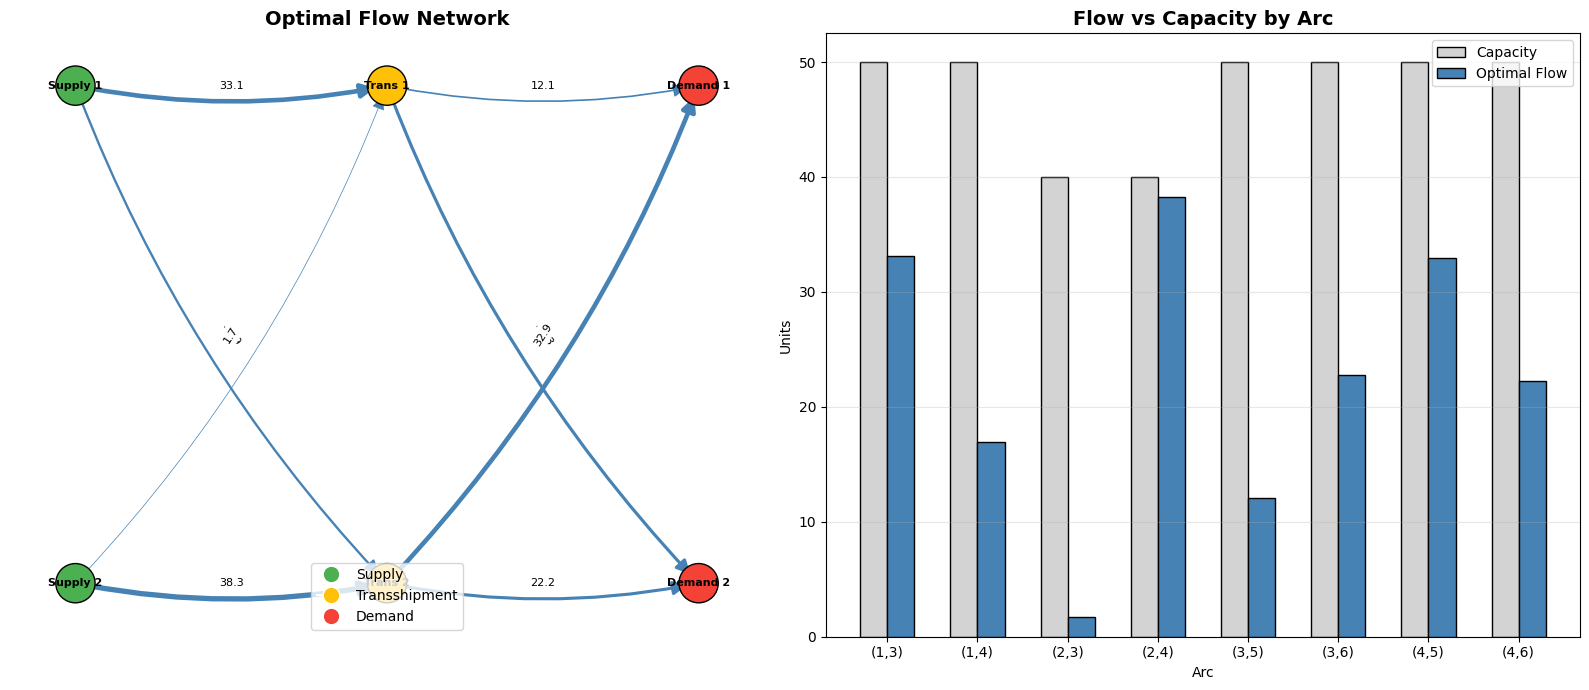

In [23]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import networkx as nx

# =============================================================================
# Nonlinear Transshipment Problem
# min sum c_ij * x_ij^alpha  (alpha != 2, so NOT quadratic)
# s.t. flow balance at each node
#      0 <= x_ij <= u_ij
# =============================================================================

# --- Network Definition ---
# Nodes: 1,2 = Supply | 3,4 = Transshipment | 5,6 = Demand
# Total supply = 50 + 40 = 90, Total demand = 45 + 45 = 90 (BALANCED)
nodes = {
    1: {'name': 'Supply 1', 'supply': 50},
    2: {'name': 'Supply 2', 'supply': 40},
    3: {'name': 'Trans 1', 'supply': 0},
    4: {'name': 'Trans 2', 'supply': 0},
    5: {'name': 'Demand 1', 'supply': -45},
    6: {'name': 'Demand 2', 'supply': -45},
}

# Arcs with higher capacities to ensure feasibility
arcs = {
    (1, 3): {'cost': 2, 'capacity': 50},
    (1, 4): {'cost': 3, 'capacity': 50},
    (2, 3): {'cost': 4, 'capacity': 40},
    (2, 4): {'cost': 1, 'capacity': 40},
    (3, 5): {'cost': 5, 'capacity': 50},
    (3, 6): {'cost': 2, 'capacity': 50},
    (4, 5): {'cost': 3, 'capacity': 50},
    (4, 6): {'cost': 4, 'capacity': 50},
}

alpha = 1.5  # Nonlinear exponent (not 2, so not quadratic)

arc_list = list(arcs.keys())
n_arcs = len(arc_list)
node_list = list(nodes.keys())
n_nodes = len(node_list)

# --- Objective Function ---
def objective(x):
    total_cost = 0
    for k, (i, j) in enumerate(arc_list):
        c = arcs[(i, j)]['cost']
        total_cost += c * (x[k] ** alpha)
    return total_cost

# --- Flow Balance Constraints ---
def make_flow_balance(node_idx):
    def constraint(x):
        node = node_list[node_idx]
        outflow = sum(x[k] for k, (i, j) in enumerate(arc_list) if i == node)
        inflow = sum(x[k] for k, (i, j) in enumerate(arc_list) if j == node)
        return (outflow - inflow) - nodes[node]['supply']
    return constraint

constraints = []
for idx in range(n_nodes):
    constraints.append({'type': 'eq', 'fun': make_flow_balance(idx)})

# --- Bounds ---
bounds = [(0.001, arcs[arc]['capacity']) for arc in arc_list]

# --- Better Initial Guess (feasible starting point) ---
# Route: Supply1->Trans1->Demand1 (25), Supply1->Trans1->Demand2 (25)
#        Supply2->Trans2->Demand1 (20), Supply2->Trans2->Demand2 (20)
x0 = np.array([25, 25, 20, 20, 25, 20, 25, 20], dtype=float)

# --- Solve ---
result = minimize(objective, x0, method='SLSQP', bounds=bounds, constraints=constraints,
                  options={'maxiter': 1000, 'ftol': 1e-12})

if result.success:
    optimal_flows = result.x
    optimal_cost = result.fun
else:
    print(f"Warning: {result.message}")
    print("Using best solution found...")
    optimal_flows = result.x
    optimal_cost = result.fun

# --- Print Results ---
print("=" * 55)
print("  NONLINEAR TRANSSHIPMENT PROBLEM SOLUTION")
print(f"  Cost function: c_ij * x_ij^{alpha}")
print("=" * 55)
print(f"\n{'Arc':<12} {'Flow':>10} {'Capacity':>10} {'Unit Cost':>10} {'Arc Cost':>10}")
print("-" * 55)
for k, (i, j) in enumerate(arc_list):
    flow = optimal_flows[k]
    cap = arcs[(i, j)]['capacity']
    c = arcs[(i, j)]['cost']
    arc_cost = c * (flow ** alpha)
    print(f"  ({i} -> {j})  {flow:>10.2f} {cap:>10.0f} {c:>10.0f} {arc_cost:>10.2f}")
print("-" * 55)
print(f"{'Total Cost:':>44} {optimal_cost:>10.2f}")

# --- Verify Flow Balance ---
print(f"\n{'Node':<15} {'Supply/Demand':>14} {'Net Flow':>10} {'Status':>10}")
print("-" * 50)
for node in node_list:
    outflow = sum(optimal_flows[k] for k, (i, j) in enumerate(arc_list) if i == node)
    inflow = sum(optimal_flows[k] for k, (i, j) in enumerate(arc_list) if j == node)
    net = outflow - inflow
    status = "OK" if abs(net - nodes[node]['supply']) < 1e-4 else "VIOLATED"
    print(f"  {nodes[node]['name']:<13} {nodes[node]['supply']:>14.1f} {net:>10.2f} {status:>10}")

# =============================================================================
# Visualization
# =============================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# --- Network Graph ---
ax1 = axes[0]
G = nx.DiGraph()
for node in node_list:
    G.add_node(node)
for (i, j) in arc_list:
    G.add_edge(i, j)

pos = {
    1: (0, 2), 2: (0, 0),
    3: (2, 2), 4: (2, 0),
    5: (4, 2), 6: (4, 0)
}

node_colors = []
for node in G.nodes():
    if nodes[node]['supply'] > 0:
        node_colors.append('#4CAF50')
    elif nodes[node]['supply'] < 0:
        node_colors.append('#F44336')
    else:
        node_colors.append('#FFC107')

nx.draw_networkx_nodes(G, pos, ax=ax1, node_color=node_colors, node_size=800, edgecolors='black')
nx.draw_networkx_labels(G, pos, ax=ax1, labels={n: nodes[n]['name'] for n in node_list}, font_size=8, font_weight='bold')

edge_widths = [max(optimal_flows[k] / 10, 0.5) for k in range(n_arcs)]
nx.draw_networkx_edges(G, pos, ax=ax1, width=edge_widths, edge_color='steelblue',
                       arrows=True, arrowsize=20, connectionstyle="arc3,rad=0.1")

edge_labels = {(i, j): f"{optimal_flows[k]:.1f}" for k, (i, j) in enumerate(arc_list)}
nx.draw_networkx_edge_labels(G, pos, ax=ax1, edge_labels=edge_labels, font_size=8)

ax1.set_title('Optimal Flow Network', fontsize=14, fontweight='bold')
ax1.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#4CAF50', markersize=12, label='Supply'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#FFC107', markersize=12, label='Transshipment'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#F44336', markersize=12, label='Demand'),
], loc='lower center')
ax1.axis('off')

# --- Flow vs Capacity Bar Chart ---
ax2 = axes[1]
arc_labels_str = [f"({i},{j})" for (i, j) in arc_list]
capacities = [arcs[arc]['capacity'] for arc in arc_list]

x_pos = np.arange(n_arcs)
ax2.bar(x_pos - 0.15, capacities, 0.3, label='Capacity', color='lightgray', edgecolor='black')
ax2.bar(x_pos + 0.15, optimal_flows, 0.3, label='Optimal Flow', color='steelblue', edgecolor='black')

ax2.set_xlabel('Arc')
ax2.set_ylabel('Units')
ax2.set_title('Flow vs Capacity by Arc', fontsize=14, fontweight='bold')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(arc_labels_str)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()